<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/05_RFM_Analysis_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kneed

In [ ]:
import warnings
from datetime import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as m
import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer)
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

# **Info**
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

@type: Mini project

**Data Info**
---

**Datos** El conjunto de datos incorpora información de las ventas minoristas, contiene todas las transacciones realizadas para una venta minorista en línea sin tienda registrada y con sede en el Reino Unido entre el 12/01/2009 y el 12/09/2011. La empresa vende principalmente artículos de regalo únicos para todas las ocasiones. Muchos clientes de la empresa son mayoristas.

path data: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci?resource=download

# **Dicionario de datos**

- **InvoiceNo**: Número de factura. Nominal. Un número integral de 6 dígitos asignado de forma única a cada transacción. Si este código comienza con la letra 'c', indica una cancelación.
- **StockCode**: Código de producto (artículo). Nominal. Un número integral de 5 dígitos asignado de forma única a cada producto distinto.
- **Description**: Nombre del producto (artículo). Nominal.
- **Quantity**: Las cantidades de cada producto (artículo) por transacción. Numérico.
- **InvoiceDate**: Fecha y hora de la factura. Numérico. El día y la hora en que se generó una transacción.
- **UnitPrice**:  Precio unitario. Numérico. Precio del producto por unidad en libras esterlinas (£).
- **CustomerID**: Número de cliente. Nominal. Un número integral de 5 dígitos asignado de forma única a cada cliente.
- **Country**: Nombre del país. Nominal. El nombre del país donde reside un cliente.

In [ ]:
def porcentaje_nulos_x_caracteristica(data:pd.DataFrame, **kwargs)->None:
  """Calcular el porcentaje de valores nulos por caracteristicas"""
  data.isnull().melt().pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            ).set(**kwargs)
        )
    )
def plot_select_params(best_score, best_x_param, scores, x_params, **kwards):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores)
  ax.plot(best_x_param, best_score, marker='o', color='r')
  ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])

def silhouette_select_cluster(model, clusters, data, **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg

  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())
  kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

  best_score = valores_medios_silhouette[kneedle.elbow]
  best_cluster = kneedle.elbow

  res_data = {
      'score': best_score,
      'cluster': best_cluster,
  }
  plot_select_params(best_score, best_cluster, y, range_n_clusters,
                        title = f'Evolución de media de los índices silhouette {kwards["name_model"]}',
                        ylabel = 'Media índices silhouette',
                        xlabel = 'Numero clusters')

  return best_cluster, best_score

def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def visulization_silhouette(data, y_predict, name, colores):
  """Visualiza el coeficiente de silhouette"""
  silhouette_avg=silhouette_score(data, y_predict)
  sample_silhouette_values = silhouette_samples(data, y_predict)
  y_lower = 5
  fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
  n_clusters = np.unique(y_predict).shape[0]
  ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
  for i in np.unique(y_predict):

    # Agregue las puntuaciones de silueta para muestras pertenecientes a
    # agrupe i, y ordénelos
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    try:
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colores[i], edgecolor=colores[i], alpha=0.7)
    except:
      pass
    # Etiquete las parcelas de silueta con sus números de grupo en el medio
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule el nuevo y_lower para la siguiente parcela
    y_lower = y_upper + 10  # 10 para las 0 muestras
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")
  plt.suptitle((f"Silhouette analysis for {name} clustering on sample data "
                  f"with n_clusters = {n_clusters}" ),
                 fontsize=14, fontweight='bold')


# **Config**
---

In [ ]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Costo de nómina afiliados CREMIL'
paleta = sns.color_palette("tab10").as_hex()
warnings.filterwarnings("ignore")
random_seedd = 12354
np.set_printoptions(precision=3, suppress=True)
sns.set(font_scale=1)


# **Proposito**

- El análisis RFM se realiza sobre los datos de los clientes para evaluar sus visitas recientes, su frecuencia y su valor monetario.

#**Data**

In [ ]:
url = 'https://drive.google.com/file/d/115bm8NVGw26dzwp-Td-G_xUjCSjNJNpQ/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

In [ ]:
data.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom


In [ ]:
# Type Change
data[
    ['Quantity', 'Price']
    ] = data[
        ['Quantity', 'Price']
        ].astype('float64')

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  float64       
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   object        
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 65.1+ MB


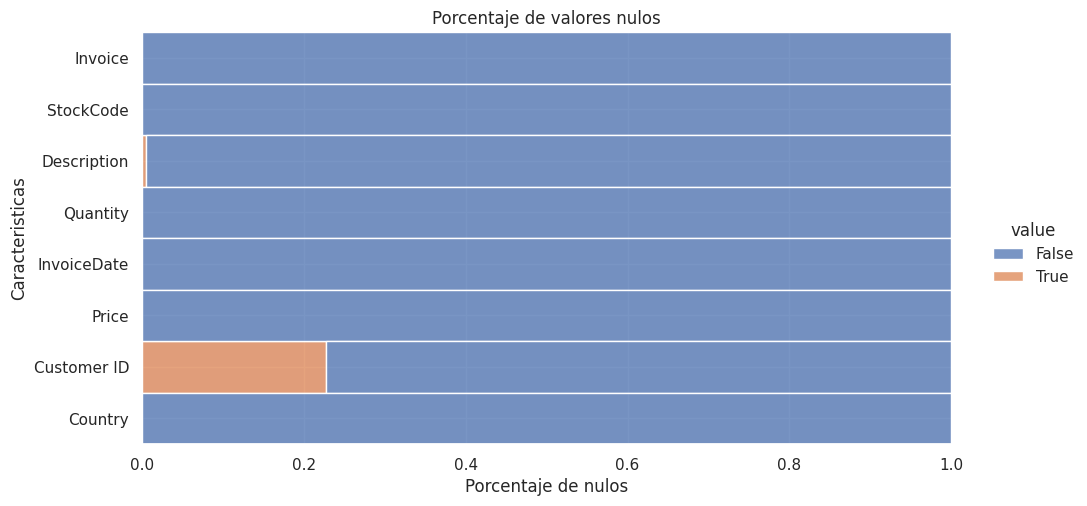

In [ ]:
# inspect data null
porcentaje_nulos_x_caracteristica(data, title="Porcentaje de valores nulos", xlabel='Porcentaje de nulos', ylabel='Caracteristicas')

In [ ]:
data['Description'].isnull().sum()

4382

- El conjunto de datos tiene 1067371 registros
- Customer ID tiene Aproximadamente 23% (243007) de valores nulos
- Descripción tiene aproximandamente 4% (4382) de valores nulos
- - Tienen 5 valores categoricos (Invoice, StockCode, Description,Customer ID, Country), 2 valores cuantitativos (Price, Quantity) y 1 una variable tipo fecha (InvoiceDate).

Note: **Para efectos del ejercicio se descartan los valores nulos correspondientes a la identificación del cliente (Customer ID), ya que es riesgoso tratar de imputar dichos valores, pues se estaría sesgando el modelo al asumir que las compras las pudieron haber realizado otros clientes.**

In [ ]:
data = data[data['Customer ID'].notnull()]
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.00,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.00,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.00,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.00,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.00,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.00,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.00,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.00,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.00,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# inspect data duplicate
data[data.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1.00,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6.00,2009-12-01 11:34:00,0.85,16329.0,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12.00,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1.00,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1.00,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067136,581538,22068,BLACK PIRATE TREASURE CHEST,1.00,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
1067150,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1.00,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
1067153,581538,22992,REVOLVER WOODEN RULER,1.00,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
1067160,581538,22694,WICKER STAR,1.00,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


**RFM Calculation**

In [ ]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

La fecha actual esta my por encima de la última fecha del conjunto de datos, por lo tanto, se empleará una fecha cercana como fecha de referencia actual. 2011-12-20 fecha antes de navidad.

In [ ]:
today = datetime( 2011 , 12 , 20 )

function_dictionary = {
    'InvoiceDate': lambda x: (today - x.max()).days,
    'Invoice': ['nunique'],
    'Price': ['sum']
}

rfm_data = data.groupby('Customer ID').aggregate(
    function_dictionary
).reset_index()

rfm_data.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']
rfm_data.sort_values(by='Recency')

,Customer ID,Recency,Frequency,Monetary
2100,14446.0,10,5,600.51
2965,15311.0,10,270,"12,703.83"
5408,17754.0,10,16,291.63
723,13069.0,10,42,"2,179.89"
1431,13777.0,10,73,"1,022.63"
...,...,...,...,...
5295,17641.0,748,1,6.95
290,12636.0,748,1,141.00
5246,17592.0,748,2,103.10
2308,14654.0,748,1,35.85


- **Customer ID**: Número de cliente
- **Recency**: cálculo más reciente es la cantidad de días desde la última compra del cliente
- **Frequency**: Suma de facturas unicas del cliente
- **moneda**: Monto total

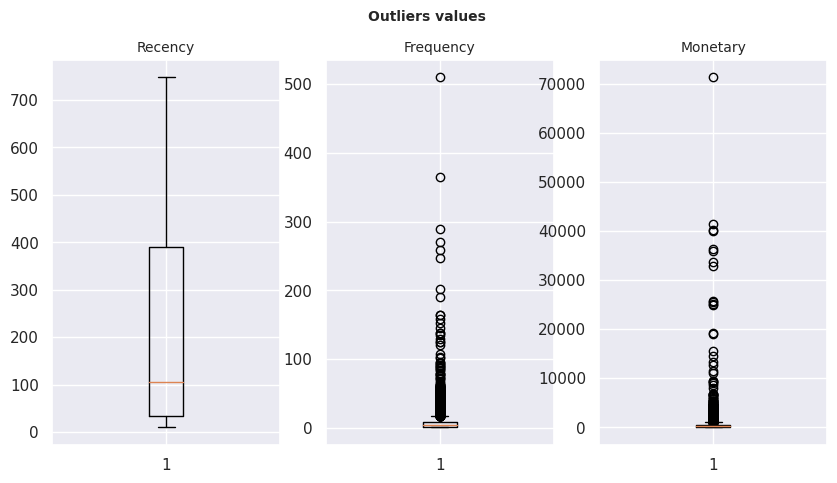

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
dtColumns = rfm_data.columns[1:]
for i, colum in enumerate(dtColumns):
  ax[i].boxplot(rfm_data[colum])
  ax[i].set_title(colum, fontsize=10)
fig.suptitle('Outliers values', fontsize = 10, fontweight = "bold");


In [ ]:
detection_anomalias= IsolationForest(
    n_estimators  = 1000,
    max_samples   ='auto',
    contamination = 0.05,
    random_state=random_seedd
)

anomalias = detection_anomalias.fit_predict(rfm_data.iloc[:, 2:])

In [ ]:
rfm_data['anomalia'] = pd.Series(anomalias)
rfm_data

,Customer ID,Recency,Frequency,Monetary,anomalia
0,12346.0,335,17,580.44,1
1,12347.0,12,8,644.16,1
2,12348.0,85,5,193.10,1
3,12349.0,28,5,"1,504.59",1
4,12350.0,320,1,65.30,1
...,...,...,...,...,...
5937,18283.0,13,22,"1,719.75",1
5938,18284.0,439,2,116.09,1
5939,18285.0,670,1,100.20,1
5940,18286.0,486,3,306.55,1


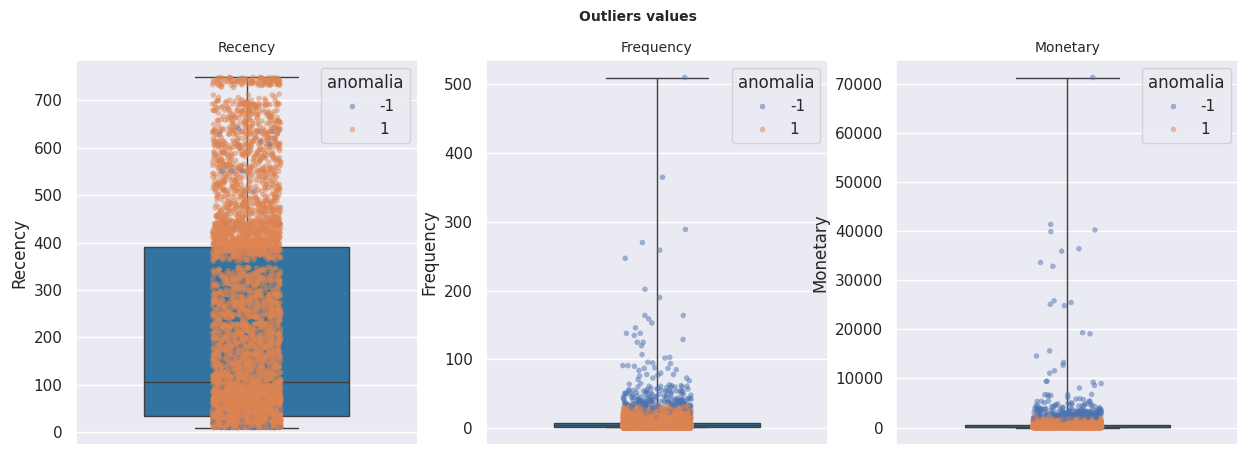

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
dtColumns = rfm_data.columns[1:-1]
for i, colum in enumerate(dtColumns):
  sns.boxplot(rfm_data, y=colum, whis=[0, 100], width=.6, palette=paleta, ax=ax[i])
  sns.stripplot(rfm_data, y=colum, hue="anomalia", size=4, palette="deep", alpha=0.5, ax=ax[i])
  ax[i].set_title(colum, fontsize=10)
fig.suptitle('Outliers values', fontsize = 10, fontweight = "bold");

- Se evidencia que las anomalías están en la variable frecuencias y en los montos, el modelo de anomalías identifica de manera congruente los atípicos de estas dos características, sin embargo, logran sesgar a la variable reciente, pero no es un sesgo muy amplio, pues los registros anómalos se encuentran en su gran mayoría al límite superior

- Normalmente, lo máximo que se puede llegar a descartar en conjunto de datos suele rondar el 10% o menos, entonces se descartara para el entrenamiento el 5%

In [ ]:
# Data scler
steps = [
    ('scaler', StandardScaler()),
]

estimator = Pipeline(
    steps=steps
)
X_train = estimator.fit_transform(rfm_data[rfm_data['anomalia']!=-1][dtColumns])
X_train

array([[ 0.542,  2.04 ,  0.763],
       [-0.979,  0.456,  0.938],
       [-0.635, -0.072, -0.298],
       ...,
       [ 2.119, -0.777, -0.552],
       [ 1.253, -0.425,  0.013],
       [-0.79 ,  0.456,  0.129]])

# **Models**
---

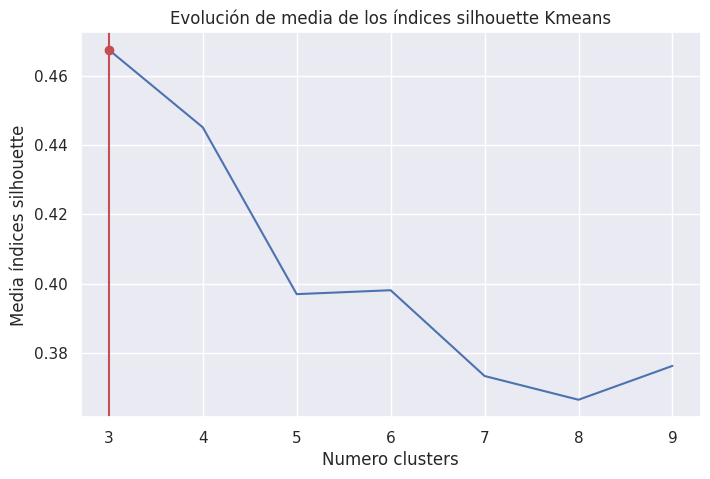

In [ ]:
model_k = KMeans(
    n_init=10,
    random_state=random_seedd)

silhouette_select_cluster(model_k, (3,10), X_train, name_model = 'Kmeans')
plt.show()

In [ ]:
n_clusters = 3
model_k = KMeans(
    n_clusters = n_clusters,
    random_state=random_seedd)
y_predict = model_k.fit_predict(X_train)
score = silhouette_score(X_train, y_predict)
print(score)

0.4675506137165101


Como no hay criterio con respecto al número de segmentos o su proporción, se procura dejar el monto que refiere un mejor coeficiente, pero se recomienda llegar a una convergencia entre la métrica y la distribución, no es buena concentración por debajo del 1%, amenos que el problema lo justifique.

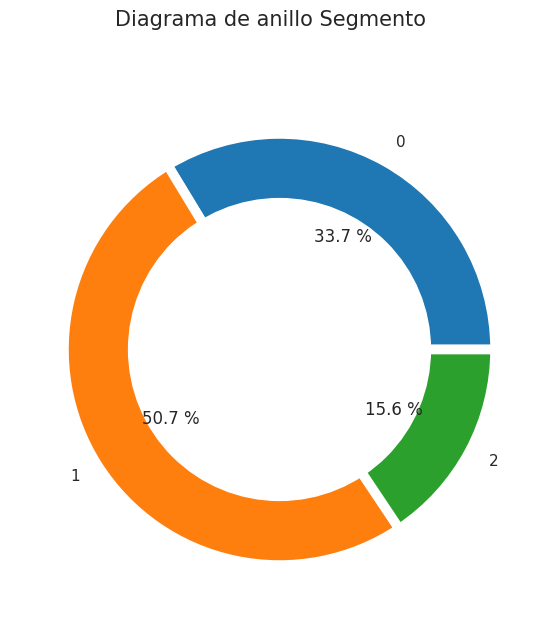

In [ ]:
pie_circle(pd.Series(y_predict), paleta=paleta, title='Segmento')

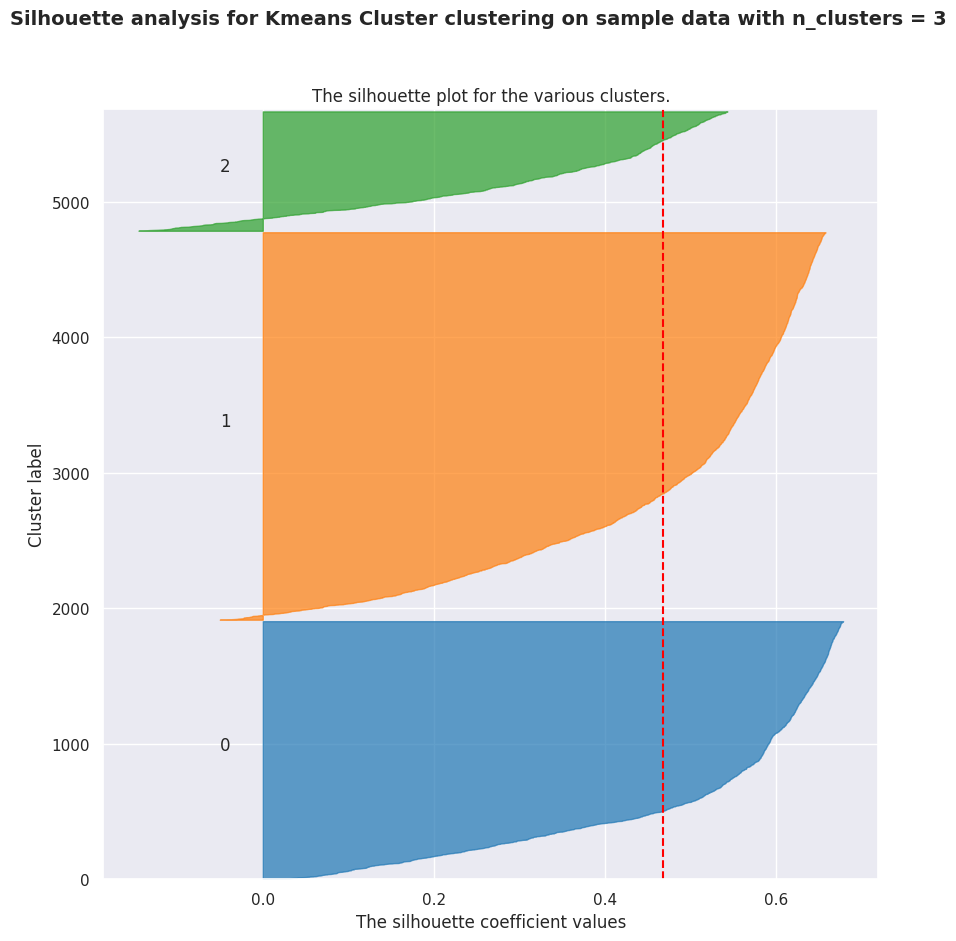

In [ ]:
visulization_silhouette(
    X_train,
    y_predict,
    'Kmeans Cluster',
    paleta)

In [ ]:
estimator = Pipeline(
    steps=steps
)
X_train = estimator.fit_transform(rfm_data[dtColumns])
X_train

array([[ 0.578,  0.592,  0.037],
       [-0.946,  0.028,  0.07 ],
       [-0.602, -0.16 , -0.165],
       ...,
       [ 2.16 , -0.41 , -0.214],
       [ 1.291, -0.285, -0.106],
       [-0.757,  0.028, -0.084]])

In [ ]:
y_predict = model_k.predict(X_train)

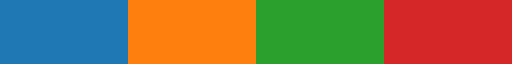

In [ ]:
cmap = m.colors.ListedColormap(paleta[0:4])
cmap

In [ ]:
rfm_data

,Customer ID,Recency,Frequency,Monetary,anomalia
0,12346.0,335,17,580.44,1
1,12347.0,12,8,644.16,1
2,12348.0,85,5,193.10,1
3,12349.0,28,5,"1,504.59",1
4,12350.0,320,1,65.30,1
...,...,...,...,...,...
5937,18283.0,13,22,"1,719.75",1
5938,18284.0,439,2,116.09,1
5939,18285.0,670,1,100.20,1
5940,18286.0,486,3,306.55,1


Text(0.5, 0, 'Monetary')

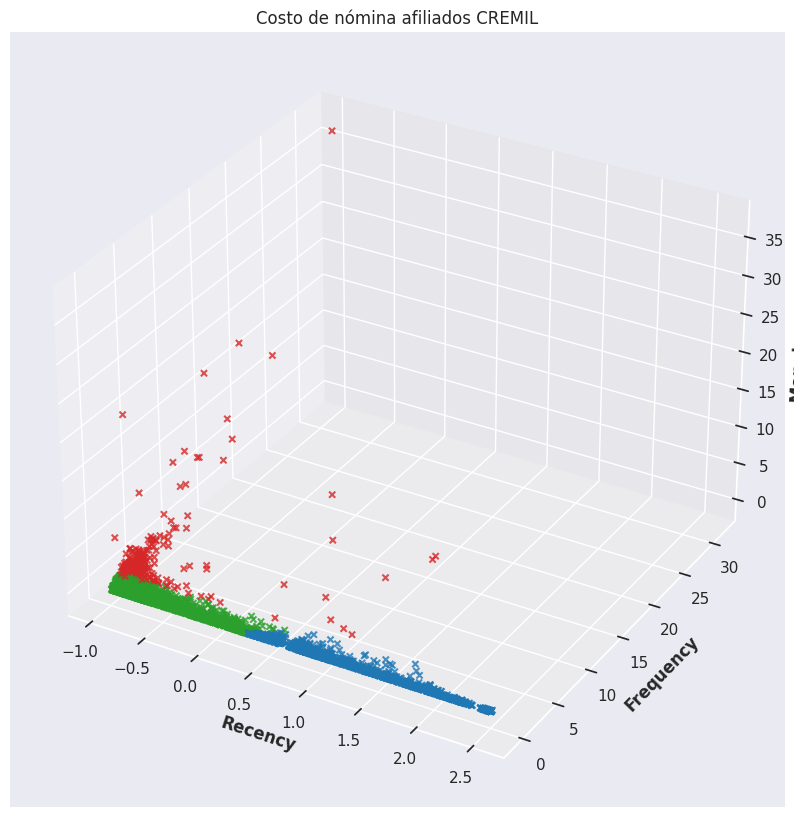

In [ ]:

fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection ="3d")

x=X_train[:,0]
y=X_train[:,1]
z=X_train[:,2]


my_cmap = plt.get_cmap('tab10')

sctt = ax.scatter3D(
    x,
    y,
    z,
    alpha = 0.8,
    c = y_predict,
    cmap = cmap,
    marker ='x')


plt.title(title_data)
ax.set_xlabel('Recency', fontweight ='bold')
ax.set_ylabel('Frequency', fontweight ='bold')
ax.set_zlabel('Monetary', fontweight ='bold')

In [ ]:
model_k.cluster_centers_

array([[ 1.244, -0.566, -0.488],
       [-0.606, -0.182, -0.243],
       [-0.716,  1.81 ,  1.84 ]])

In [ ]:
estimator.inverse_transform(model_k.cluster_centers_)

array([[484.039,   2.199, 123.55 ],
       [ 91.217,   4.376, 213.175],
       [ 67.899,  15.693, 973.487]])